In [1]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock

In [2]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)

def get_blockerror_pyblock_max(Data):
    average=np.average(Data)
    if (average!=0) and (average!=1):
        reblock_data = pyblock.blocking.reblock(Data)
        be_max=0
        for i in range(0,len(reblock_data)): 
            be=reblock_data[i][4]
            if(be > be_max):
                be_max=be
    else:
        be=0
    return average,float(be)


In [3]:
def calc_SA(trj, helix, start, stop):
    r0 = .10
    RMS_start = start
    RMS_stop = stop
    RMS = []
    for i in range(RMS_start, RMS_stop):
        sel = helix.topology.select("residue %s to %s and name CA" % (i, i+6))
        rmsd = md.rmsd(trj, helix, atom_indices=sel)
        RMS.append(rmsd)
    RMS = np.asarray(RMS)
    Sa_sum = np.zeros((trj.n_frames))
    Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
    return Sa


def calc_Rg(trj):
    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    return rg_CA


def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_reweight(a, b, T, y0, ymax, x0, xmax, weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_1D_noscale(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    free_energy = np.log(free_energy+.000001)
    free_energy = -(0.001987*T)*free_energy
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D_reweight(a, T, x0, xmax, bins, weight):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=weight)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E


def calc_phipsi(trj):
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    phipsi = []
    for i in range(0, len(phi_label)-1):
        current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    return(phipsi_array, psi_label, phi_label)


In [4]:
# Functions to Calculate Aromatic Stacking Interactions
from __future__ import print_function, division
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles


def find_plane_normal(points):

    N = points.shape[0]
    A = np.concatenate((points[:, 0:2], np.ones((N, 1))), axis=1)
    B = points[:, 2]
    out = lstsq(A, B, rcond=-1)
    na_c, nb_c, d_c = out[0]
    if d_c != 0.0:
        cu = 1./d_c
        bu = -nb_c*cu
        au = -na_c*cu
    else:
        cu = 1.0
        bu = -nb_c
        au = -na_c
    normal = np.asarray([au, bu, cu])
    normal /= math.sqrt(dot(normal, normal))
    return normal


def find_plane_normal2(positions):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    # Use Ligand IDs 312, 308 and 309 to check direction
    # [304 305 306 307 308 309 310 311 312 313]
    v1 = positions[0]-positions[1]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[2]-positions[1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def find_plane_normal2_assign_atomid(positions, id1, id2, id3):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    v1 = positions[id1]-positions[id2]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[id3]-positions[id1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def get_ring_center_normal_assign_atomid(positions, id1, id2, id3):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2_assign_atomid(positions, id1, id2, id3)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def get_ring_center_normal_(positions):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2(positions)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))


def get_ring_center_normal_trj_assign_atomid(position_array, id1, id2, id3):
    length = len(position_array)
    centers = np.zeros((length, 3))
    normals = np.zeros((length, 3))
    centers_normals = np.zeros((length, 2, 3))
    print(np.shape(length), np.shape(centers), np.shape(normals))
    for i in range(0, len(position_array)):
        center, normal = get_ring_center_normal_assign_atomid(
            position_array[i], id1, id2, id3)
        centers_normals[i][0] = center
        centers_normals[i][1] = normal
    return centers_normals

# MDtraj Functions to Calculate Hydrogen Bonds with custom selections of donors and acceptors

def _get_bond_triplets_print(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        # print("get_donors e0 e1:",e0,e1)
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    print("nh_donors", nh_donors)
    for i in nh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    oh_donors = get_donors('O', 'H')
    print("oh_donors", oh_donors)
    for i in oh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    sh_donors = get_donors('S', 'H')
    print("sh_donors", sh_donors)
    for i in sh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    for i in lig_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    # ADD IN ADDITIONAL SPECIFIED LIGAND DONORS
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    print("acceptors")
    for i in acceptors:
        print(top.atom(i))
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _get_bond_triplets(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    oh_donors = get_donors('O', 'H')
    sh_donors = get_donors('S', 'H')
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _compute_bounded_geometry(traj, triplets, distance_cutoff, distance_indices,
                              angle_indices, freq=0.0, periodic=True):
    """
    Returns a tuple include (1) the mask for triplets that fulfill the distance
    criteria frequently enough, (2) the actual distances calculated, and (3) the
    angles between the triplets specified by angle_indices.
    """
    # First we calculate the requested distances
    distances = md.compute_distances(
        traj, triplets[:, distance_indices], periodic=periodic)

    # Now we discover which triplets meet the distance cutoff often enough
    prevalence = np.mean(distances < distance_cutoff, axis=0)
    mask = prevalence > freq

    # Update data structures to ignore anything that isn't possible anymore
    triplets = triplets.compress(mask, axis=0)
    distances = distances.compress(mask, axis=1)

    # Calculate angles using the law of cosines
    abc_pairs = zip(angle_indices, angle_indices[1:] + angle_indices[:1])
    abc_distances = []

    # Calculate distances (if necessary)
    for abc_pair in abc_pairs:
        if set(abc_pair) == set(distance_indices):
            abc_distances.append(distances)
        else:
            abc_distances.append(md.compute_distances(traj, triplets[:, abc_pair],
                                                      periodic=periodic))

    # Law of cosines calculation
    a, b, c = abc_distances
    cosines = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)
    np.clip(cosines, -1, 1, out=cosines)  # avoid NaN error
    angles = np.arccos(cosines)
    return mask, distances, angles


def baker_hubbard2(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                   distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    add_donors = lig_donor_index

    bond_triplets = _get_bond_triplets(traj.topology,
                                       exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
                                                        distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    presence = np.logical_and(
        distances < distance_cutoff, angles > angle_cutoff)
    mask[mask] = np.mean(presence, axis=0) > freq
    return bond_triplets.compress(mask, axis=0)


def print_donors_acceptors(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                           distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    # add_donors=[[296,318],[296,331]]
    # Manually tell it where to find proton donors on ligand
    # LIG58-O5 LIG58-H24
    # LIG58-O1 LIG58-H12
    # LIG58-N LIG58-H15
    # add_donors=[[768,796],[750,784],[752,787]]
    add_donors = lig_donor_index

    bond_triplets_print = _get_bond_triplets_print(traj.topology,
                                                   exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    # mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
    #    distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    # presence = np.logical_and(distances < distance_cutoff, angles > angle_cutoff)
    # mask[mask] = np.mean(presence, axis=0) > freq
    return


In [5]:
outdir = '/Users/achakrab/Documents/asn/tica/lig_47/'
pdb = '/Users/achakrab/Documents/asn/tica/lig_47/lig47.pdb'
rep0 = '/Users/achakrab/Documents/asn/tica/lig_47/lig_47_cluster_3.dcd'
#helixpdb = './xtc/anton/Sa.pdb'
#ppIIpdb = './xtc/anton/ppII.pdb'


#Attached Amine Hydrogens are 318 and 331
#Sulfoynl Oxygens are O-302 and O-303
#Sulfonyl S is S-301
#Ring 1 is C-304-309
#Ring 2 is C-308-313
#Single Ring is 304-313

# Define Aromatic Rings
ligand_rings=[[307,308,309,311,313,314]]

# Definie Hydrogen Bond Donors
lig_hbond_donors=[[329,331],[329,330]]

#Select Ligand Charge Groups
#Ligand Charged atom is N-296
Ligand_Pos_Charges=[329]
Ligand_Neg_Charges=[]

# Simulation Length in microseconds
sim_length = 100
print("outdir:", outdir)
print("pdb:", pdb)
#print("helix pdb:", helixpdb)
print("trjaectory:", rep0)


outdir: /Users/achakrab/Documents/asn/tica/lig_47/
pdb: /Users/achakrab/Documents/asn/tica/lig_47/lig47.pdb
trjaectory: /Users/achakrab/Documents/asn/tica/lig_47/lig_47_cluster_3.dcd


In [6]:
trj = md.load(rep0, top=pdb)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames


In [7]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues = 21
residue_offset = 0
prot_res_renum = np.asarray(prot_res) +residue_offset
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:", residue_number)


** SYSTEM INFO **

Number of atoms: 338

Number of residues: 21

Number of protein residues: 20

Number of frames: 366593

Starting frame: 0

Last frame: 366593

sequence:  [ASP121, ASN122, GLU123, ALA124, TYR125, GLU126, MET127, PRO128, SER129, GLU130, GLU131, GLY132, TYR133, GLN134, ASP135, TYR136, GLU137, PRO138, GLU139, ALA140, ASP121, <1>1]

residue names:  ['ASP', 'ASN', 'GLU', 'ALA', 'TYR', 'GLU', 'MET', 'PRO', 'SER', 'GLU', 'GLU', 'GLY', 'TYR', 'GLN', 'ASP', 'TYR', 'GLU', 'PRO', 'GLU', 'ALA', 'ASP', '<1>']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

Residue Number Range: range(0, 21)


In [8]:
trj.topology.select("resid 21")

array([294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332,
       333, 334, 335, 336, 337])

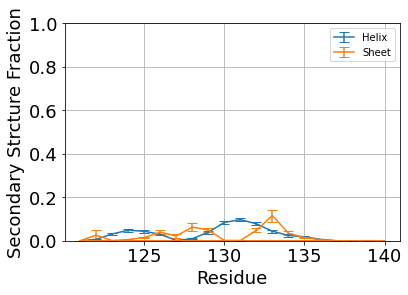

In [9]:
#Protein Only Properties
prot_traj = md.load(rep0, top=pdb,stride=1)
prot=prot_traj.topology.select("resid 0 to 20")
prot_traj.restrict_atoms(prot)
prot_traj.center_coordinates()
frames=prot_traj.n_frames
#time=np.linspace(0,200,prot_traj.n_frames)


dssp=md.compute_dssp(prot_traj, simplified=True)
H1_H,H1_E=dssp_convert(dssp)

prot_res=[]
for res in prot_traj.topology.residues: prot_res.append(res.resSeq)
prot_residues=len(set(prot_res))
residue_offset=0
prot_renum=np.asarray(prot_res)+residue_offset

plt.errorbar(prot_renum,H1_H[:,0],yerr=H1_H[:,1], capsize=5,label='Helix')
plt.errorbar(prot_renum,H1_E[:,0],yerr=H1_E[:,1], capsize=5,label='Sheet')

plt.ylim(0,1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
plt.grid()
#np.savetxt(outdir+'Hprop.err.dat',np.column_stack((prot_renum,H1_H[:,0],H1_H[:,1])))
#np.savetxt(outdir+'Eprop.err.dat',np.column_stack((prot_renum,H1_E[:,0],H1_E[:,1])))

In [10]:
dsspH=np.copy(dssp)
dsspH[dsspH=='H']=1                                                                                      
dsspH[dsspH=='E']=0                                                                                      
dsspH[dsspH=='C']=0                                                                                      
dsspH[dsspH=='NA']=0 
dsspH=dsspH.astype(int)
TotalH=np.sum(dsspH,axis=1) 
prot_res=20
print("Averagr Helical Residues/Frame:%6.3lf"%(np.average(TotalH)),"+_%6.3lf"%((block(TotalH)**.5)))
print("Averagr Fraction Helix:%6.3lf"%(np.average(TotalH)/prot_res),"+_%6.3lf"%((block(TotalH)**.5)/prot_res))

dsspE=np.copy(dssp)
dsspE[dsspE=='H']=0                                                                                      
dsspE[dsspE=='E']=1                                                                                      
dsspE[dsspE=='C']=0                                                                                      
dsspE[dsspE=='NA']=0 
dsspE=dsspE.astype(int)
TotalE=np.sum(dsspE,axis=1) 
print("Average Sheet Residues/Frame:%6.3lf"%(np.average(TotalE)),"+_%6.3lf"%((block(TotalE)**.5)))
print("Average Fraction Sheet:%6.3lf"%(np.average(TotalE)/prot_res),"+_%6.3lf"%((block(TotalE)**.5)/prot_res))


Averagr Helical Residues/Frame: 0.566 +_ 0.040
Averagr Fraction Helix: 0.028 +_ 0.002
Average Sheet Residues/Frame: 0.445 +_ 0.087
Average Fraction Sheet: 0.022 +_ 0.004


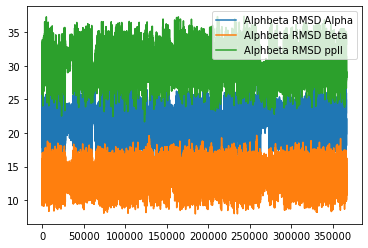

In [11]:
#Compute Phi and Psi
#phipsi_array,psi_labels,phi_labels=calc_phipsi(trj)
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
np.savetxt(outdir+"/phis.dat",phis,fmt="%.3f")
np.savetxt(outdir+"/psis.dat",psis,fmt="%.3f")

Phi_all=phis
Psi_all=psis
alphabeta_alpharight=alphabeta_rmsd(Phi_all,Psi_all,-1.05,-0.79)
alphabeta_betasheet=alphabeta_rmsd(Phi_all,Psi_all,2.36,-2.36)
alphabeta_ppII=alphabeta_rmsd(Phi_all,Psi_all,-1.31,2.71)

plt.plot(alphabeta_alpharight,label='Alphbeta RMSD Alpha')
plt.plot(alphabeta_betasheet,label='Alphbeta RMSD Beta')
plt.plot(alphabeta_ppII,label='Alphbeta RMSD ppII')
plt.legend()

In [12]:
#Select Ligand Residues
ligand=top.select("resid 21")
#Select Protein Residues
protein=top.select("resid 0 to 20")
#table, bonds = top.to_dataframe()
#table[table['resName'] == '*']

ligand_atomid = []
for atom in ligand:
    indices = []
    indices.append(atom)
    indices.append(top.atom(atom))
    ligand_atomid.append(indices)


protein_atomid = []
for atom in protein:
    indices = []
    indices.append(atom)
    indices.append(top.atom(atom))
    protein_atomid.append(indices)

print(ligand_atomid)
print(protein_atomid)

[[294, <1>1-C], [295, <1>1-H], [296, <1>1-H], [297, <1>1-H], [298, <1>1-C], [299, <1>1-O], [300, <1>1-N], [301, <1>1-C], [302, <1>1-H], [303, <1>1-H], [304, <1>1-C], [305, <1>1-H], [306, <1>1-H], [307, <1>1-C], [308, <1>1-C], [309, <1>1-C], [310, <1>1-H], [311, <1>1-C], [312, <1>1-H], [313, <1>1-C], [314, <1>1-C], [315, <1>1-H], [316, <1>1-S], [317, <1>1-O], [318, <1>1-O], [319, <1>1-N], [320, <1>1-C], [321, <1>1-H], [322, <1>1-H], [323, <1>1-C], [324, <1>1-H], [325, <1>1-H], [326, <1>1-C], [327, <1>1-H], [328, <1>1-H], [329, <1>1-N], [330, <1>1-H], [331, <1>1-H], [332, <1>1-C], [333, <1>1-H], [334, <1>1-H], [335, <1>1-C], [336, <1>1-H], [337, <1>1-H]]
[[0, ASP121-N], [1, ASP121-CA], [2, ASP121-C], [3, ASP121-O], [4, ASP121-CB], [5, ASP121-CG], [6, ASP121-OD1], [7, ASP121-OD2], [8, ASP121-H], [9, ASP121-HA], [10, ASP121-HB2], [11, ASP121-HB3], [12, ASN122-N], [13, ASN122-CA], [14, ASN122-C], [15, ASN122-O], [16, ASN122-CB], [17, ASN122-CG], [18, ASN122-OD1], [19, ASN122-ND2], [20, ASN1

Fraction Bound: 0.9944270621643075


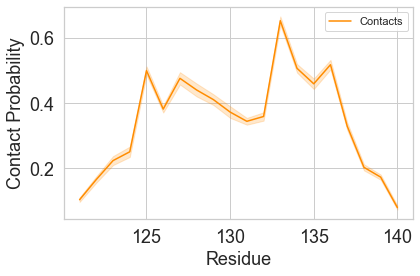

In [13]:
residues = 21
residue_offset = 121
residue_number = range(0, residues)
residue_number_offset = range(residue_offset, residue_offset+residues)

# Calculate Contact Probabilities between each protein residue and the ligand
#residue_number = range(residue_offset, residue_offset+residues)
contact_pairs = np.zeros((residues-1, 2))
ligand_residue_index = 21

for i in range(0, residues-1):
    contact_pairs[i] = [i, ligand_residue_index]
contact = md.compute_contacts(trj, contact_pairs, scheme='closest-heavy')


contacts = np.asarray(contact[0]).astype(float)
cutoff = 0.6
contact_matrix = np.where(contacts < cutoff, 1, 0)
contact_prob = np.sum(contact_matrix, axis=0)/trj.n_frames
np.savetxt(outdir+'contacts.traj.dat', contact_matrix, '%i')


contact_rows = np.sum(contact_matrix, axis=1)
contact_frames = np.where(contact_rows > 0)[0]
nocontact_frames = np.where(contact_rows == 0)[0]
contact_fraction = np.sum(np.where(contact_rows > 0, 1, 0))/len(contact_rows)
print("Fraction Bound:", contact_fraction)

contact_ave, contact_pyb_be = get_blockerrors_pyblock(contact_matrix, 1.0)
contact_ave, contact_pyb_be_max = get_blockerrors_pyblock(contact_matrix, 1.0)

resnum = range(121,141)
contact_be = np.column_stack((resnum, contact_ave, contact_pyb_be))
contact_be_max = np.column_stack((resnum, contact_ave, contact_pyb_be_max))

np.savetxt('%s/contact.be.pyblock.dat' % outdir, contact_be, '%.4f')
np.savetxt('%s/contact.be.pyblock.max.dat' % outdir, contact_be_max, '%.4f')
sns.set(style='whitegrid')

Contact = contact_be
sns.lineplot(x=Contact[:, 0], y=Contact[:, 1],
             color='darkorange', label='Contacts')
#plt.plot(Contact[:, 0], Contact[:, 1],color='darkorange', label='Contacts')


plt.fill_between(Contact[:, 0], Contact[:, 1]+Contact[:, 2],
                 Contact[:, 1]-Contact[:, 2], color='darkorange', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Contact Probability', size=18)
#plt.ylim(0, 0.5)
plt.tick_params(labelsize=18)
#plt.xlim(residue_offset, residue_offset+residues-1)
plt.tight_layout()
plt.savefig(outdir+'ContactFraction.byResidue.ClosestHeavy.png')
plt.show()
#plt.ylim(0, 0.5)
#plt.clf()


In [14]:
Box_L = trj.unitcell_lengths[0][0]
# Convert nM to meters for Box_V in M^3
Box_V = (Box_L*10**-9)**3
# Convert Box_V to L
Box_V_L = Box_V*1000
#Concentraion in Mols/L
Concentration = 1/(Box_V_L*(6.023*10**23))
print("L:", Box_L, "V:", Box_V, "Conc:", Concentration)

contact_binary = np.where(contact_rows > 0, 1, 0)
boundfrac, boundfrac_be = get_blockerror_pyblock(contact_binary)
print("Bound Fraction:", boundfrac, "+_", boundfrac_be)
upper = boundfrac+boundfrac_be
KD = Kd_calc(boundfrac, Concentration)
KD_upper = Kd_calc(upper, Concentration)
KD_error = KD-KD_upper
print("KD (mM):", KD*1000, "+_", KD_error*1000)


L: 4.254648 V: 7.701777537942805e-26 Conc: 0.021557389405450513
Bound Fraction: 0.9944270621643075 +_ 0.00021165741421527864
KD (mM): 0.12081126472455227 +_ 0.004613083935273355


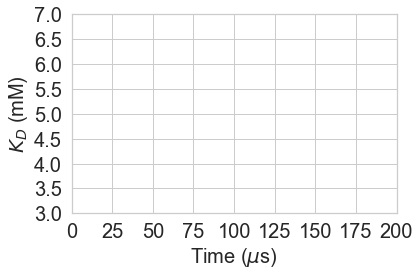

In [15]:
# Time Series of KD Calculations
sim_length=200 #in micro-secs

time = np.linspace(0, sim_length, len(contact_binary))
boundfrac_by_frame = []
t2 = []
err_by_frame = []
err_upper = []
err_lower = []
stride = 10

for i in range(stride, len(contact_binary), stride):
    Data = np.asarray(contact_binary[0:i])
    bf, be = get_blockerror_pyblock_nanskip(Data)
    boundfrac_by_frame.append(bf)
    err_by_frame.append(be)
    err_upper.append(bf-be)
    err_lower.append(bf+be)
    t2.append(time[i])

Kd = Kd_calc(np.asarray(boundfrac_by_frame), Concentration)*1000
Kd_upper = Kd_calc(np.asarray(err_upper), Concentration)*1000
Kd_lower = Kd_calc(np.asarray(err_lower), Concentration)*1000
np.savetxt('%s/KD.timecourse.errors.dat' %
           (outdir), np.column_stack((t2, Kd, Kd_upper, Kd_lower)), '%.4f')

# KD_upper=err_upper
plt.plot(t2, Kd, color='blue')
plt.fill_between(t2, Kd_upper, Kd_lower, color='blue', alpha=0.2)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time ($\mu$s)', fontsize=20)
plt.ylabel('$K_D$ (mM)', fontsize=20)
plt.grid(True)
plt.ylim(3, 7)
plt.xlim(0, sim_length)
plt.tight_layout()
plt.savefig(outdir+'KD.bytime.blockerrors.pdf', bbox_inches='tight')


In [16]:
def add_charge_pair(pairs,pos,neg,contact_prob):
    if pos not in pairs: 
        pairs[pos] = {} 
    if neg not in pairs[pos]:
        pairs[pos][neg] = {}
    pairs[pos][neg] = contact_prob

#Select Protein Charge Groups
#Add Apropriate HIS name if there is a charged HIE OR HIP in the structure 
Protein_Pos_Charges=top.select("(resname ARG and name CZ) or (resname LYS and name NZ) or (resname HIE and name NE2) or (resname HID and name ND1)")
#Protein_Neg_Charges=[]
Protein_Neg_Charges=top.select("(resname ASP and name CG) or (resname GLU and name CD) or (name OXT) or (resname NASP and name CG)")
neg_res=[]
pos_res=[]
                               
for i in Protein_Neg_Charges:
    neg_res.append(top.atom(i).residue.resSeq)

for i in Protein_Pos_Charges:
    pos_res.append(top.atom(i).residue.resSeq)                               
                               
print("Negatively Charged Residues:", neg_res)
print("Posiitively Charged Residues", pos_res)


Negatively Charged Residues: [121, 123, 126, 130, 131, 135, 137, 139, 140]
Posiitively Charged Residues []


In [17]:
charge_pairs_ligpos=[]                      
for i in Ligand_Pos_Charges:
    for j in Protein_Neg_Charges:              
        charge_pairs_ligpos.append([i,j])
        pos=top.atom(i)
        neg=top.atom(j) 

charge_pairs_ligneg=[]                      
for i in Ligand_Neg_Charges:
    for j in Protein_Pos_Charges:              
        charge_pairs_ligneg.append([i,j])
        pos=top.atom(i)
        neg=top.atom(j) 

if len(charge_pairs_ligpos) != 0:
    contact  = md.compute_distances(trj, charge_pairs_ligpos)
    contacts = np.asarray(contact).astype(float)
    cutoff=0.5
    neg_res_contact_frames=np.where(contacts < 0.5, 1, 0)
    contact_prob_ligpos = np.sum(neg_res_contact_frames,axis=0)/trj.n_frames

if len(charge_pairs_ligneg) != 0:
    contact  = md.compute_distances(trj, charge_pairs_ligneg)
    contacts = np.asarray(contact).astype(float)
    cutoff=0.5
    pos_res_contact_frames=np.where(contacts < 0.5, 1, 0)
    contact_prob_ligneg = np.sum(pos_res_contact_frames,axis=0)/trj.n_frames

charge_pair_names={}
for i in range(0,len(charge_pairs_ligpos)):
    pos=top.atom(charge_pairs_ligpos[i][0])
    neg=top.atom(charge_pairs_ligpos[i][1])      
    add_charge_pair(charge_pair_names,pos,neg,contact_prob_ligpos[i])

for i in range(0,len(charge_pairs_ligneg)):
    pos=top.atom(charge_pairs_ligneg[i][1])
    neg=top.atom(charge_pairs_ligneg[i][0])      
    add_charge_pair(charge_pair_names,pos,neg,contact_prob_ligneg[i])

print(charge_pair_names)


{<1>1-N: {ASP121-CG: 0.01960484788307469, GLU123-CD: 0.034416914671038454, GLU126-CD: 0.06060672189594455, GLU130-CD: 0.049698166631659636, GLU131-CD: 0.04107279735292273, ASP135-CG: 0.1297269724190042, GLU137-CD: 0.0565668193337025, GLU139-CD: 0.03774485601198059, ALA140-OXT: 0.03205734970389505}}


[[1.21000000e+02 1.96048479e-02]
 [1.22000000e+02 0.00000000e+00]
 [1.23000000e+02 3.44169147e-02]
 [1.24000000e+02 0.00000000e+00]
 [1.25000000e+02 0.00000000e+00]
 [1.26000000e+02 6.06067219e-02]
 [1.27000000e+02 0.00000000e+00]
 [1.28000000e+02 0.00000000e+00]
 [1.29000000e+02 0.00000000e+00]
 [1.30000000e+02 4.96981666e-02]
 [1.31000000e+02 4.10727974e-02]
 [1.32000000e+02 0.00000000e+00]
 [1.33000000e+02 0.00000000e+00]
 [1.34000000e+02 0.00000000e+00]
 [1.35000000e+02 1.29726972e-01]
 [1.36000000e+02 0.00000000e+00]
 [1.37000000e+02 5.65668193e-02]
 [1.38000000e+02 0.00000000e+00]
 [1.39000000e+02 3.77448560e-02]
 [1.40000000e+02 3.20573497e-02]
 [1.41000000e+02 0.00000000e+00]]


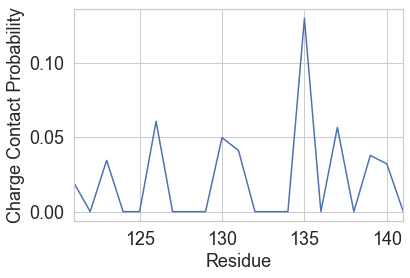

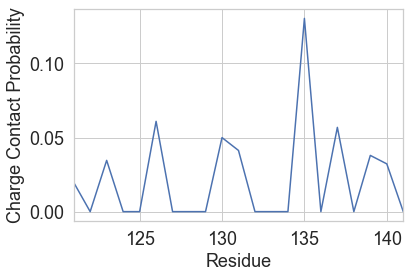

In [18]:
residues=21
residue_offset=121
residue_number = range(residue_offset, residue_offset+residues)
neg_res_index=np.array(neg_res)-residue_offset
Charge_Contacts=np.zeros((n_frames,residues))

for i in range(0,len(neg_res)):
    Charge_Contacts[:,neg_res[i]-residue_offset]=neg_res_contact_frames[:,i]

charge_contact_fraction=np.average(Charge_Contacts,axis=0)
np.savetxt(outdir+'charge_contacts.traj.dat', Charge_Contacts,'%i')
np.savetxt(outdir+'charge_contacts.dat',np.column_stack((residue_number, charge_contact_fraction)),fmt='%.4f')
charge_by_res=np.column_stack((residue_number, charge_contact_fraction))
print(charge_by_res)


#np.savetxt('charge_contacts.BF.0.7325bf.dat',np.column_stack((residue_number, charge_contact_fraction/desres_bf)),fmt='%.4f')




plt.plot(residue_number,charge_contact_fraction)
plt.xlabel('Residue', size=18)
plt.ylabel('Charge Contact Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.tight_layout()
plt.savefig('ChargeContactFraction.png')
#plt.clf()
plt.show()

plt.plot(residue_number,charge_contact_fraction/boundfrac)
plt.xlabel('Residue', size=18)
plt.ylabel('Charge Contact Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.tight_layout()
plt.savefig('ChargeContactFraction.0.7325bf.png')
#plt.clf()

In [19]:
ligand_hphob = top.select("resid 21 and element C")
protein_hphob = top.select("resid 0 to 20 and element C and not name CA")


ligand_hphob_atoms = []
for atom in ligand_hphob:
    ligand_hphob_atoms.append(top.atom(atom))

protein_hphob_atoms = []
for atom in protein_hphob:
    protein_hphob_atoms.append(top.atom(atom))

print(ligand_hphob)
print(ligand_hphob_atoms)

def add_contact_pair(pairs, a1, a2, a1_id, a2_id, prot_res, contact_prob):
    if prot_res not in pairs:
        pairs[prot_res] = {}
    if a2 not in pairs[prot_res]:
        pairs[prot_res][a2] = {}
    if a1_id not in pairs[prot_res][a2]:
        pairs[prot_res][a2][a1_id] = contact_prob


hphob_pairs = []
for i in ligand_hphob:
    for j in protein_hphob:
        hphob_pairs.append([i, j])


contact = md.compute_distances(trj, hphob_pairs)
contacts = np.asarray(contact).astype(float)
cutoff = 0.4
contact_frames = np.where(contacts < cutoff, 1, 0)
contact_prob_hphob = np.sum(contact_frames, axis=0)/trj.n_frames


# Hphob Contacts at Atom Pair Resolution
hphob_pair_names = {}
for i in range(0, len(hphob_pairs)):
    a1_id = hphob_pairs[i][0]
    a2_id = hphob_pairs[i][1]
    a1 = top.atom(hphob_pairs[i][0])
    a2 = top.atom(hphob_pairs[i][1])
    prot_res = top.atom(hphob_pairs[i][1]).residue.resSeq
    add_contact_pair(hphob_pair_names, a1, a2, a1_id,
                     a2_id, prot_res, contact_prob_hphob[i])

#residue_number = range(residue_offset, residue_offset+residues)
hphob_max_contacts = {}

# Print Most Populated Contact For Each Aliphatic Carbon in the protein
for i in range(121,141):
    if i in hphob_pair_names.keys():
        maxi = 0
        for j in hphob_pair_names[i]:
            max_contact_j = max(
                hphob_pair_names[i][j], key=hphob_pair_names[i][j].get)
            max_contact_fraction = hphob_pair_names[i][j][max_contact_j]
            if max_contact_fraction > maxi:
                max_key_j = j
                max_j_subkey = max_contact_j
                maxi = max_contact_fraction
        hphob_max_contacts[i] = [max_key_j, max_j_subkey, top.atom(
            max_j_subkey), hphob_pair_names[i][max_key_j][max_j_subkey]]


[294 298 301 304 307 308 309 311 313 314 320 323 326 332 335]
[<1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C, <1>1-C]


In [20]:
print("Most Populatd Hydrophobic Contact by Residue:")
for i in hphob_max_contacts:
    print(hphob_max_contacts[i])

Most Populatd Hydrophobic Contact by Residue:
[ASP121-CG, 332, <1>1-C, 0.004487265168729354]
[ASN122-CB, 308, <1>1-C, 0.007482412375577275]
[GLU123-CD, 332, <1>1-C, 0.010256606099952808]
[ALA124-CB, 309, <1>1-C, 0.010714879989525168]
[TYR125-CZ, 308, <1>1-C, 0.0714361703578628]
[GLU126-CD, 326, <1>1-C, 0.017106164056596825]
[MET127-CE, 308, <1>1-C, 0.021369747922082526]
[PRO128-CD, 309, <1>1-C, 0.022924605761703035]
[SER129-CB, 309, <1>1-C, 0.01474932691022469]
[GLU130-C, 332, <1>1-C, 0.014187395831344297]
[GLU131-C, 332, <1>1-C, 0.015286707602163708]
[GLY132-C, 304, <1>1-C, 0.009713769766471264]
[TYR133-CZ, 308, <1>1-C, 0.08425420016203256]
[GLN134-CB, 309, <1>1-C, 0.01579408226561882]
[ASP135-CG, 326, <1>1-C, 0.03276658310442371]
[TYR136-CZ, 308, <1>1-C, 0.07685089458882194]
[GLU137-CD, 332, <1>1-C, 0.01581590483178893]
[PRO138-CD, 308, <1>1-C, 0.02147340511139056]
[GLU139-C, 332, <1>1-C, 0.01232702206534222]
[ALA140-C, 332, <1>1-C, 0.013246297665258202]


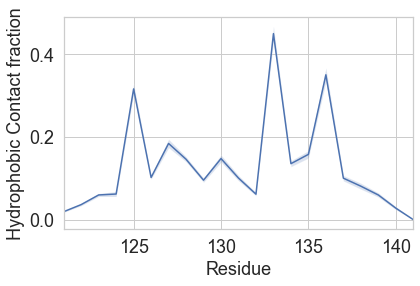

<Figure size 432x288 with 0 Axes>

In [21]:
# Cast hydrophobic contacts as per residue in each frame
residues = 21
residue_offset = 121
residue_number = range(0, residues)
residue_number_offset = range(residue_offset, residue_offset+residues)


Hphob_res_contacts = np.zeros((n_frames, residues))
for frame in range(n_frames):
    if np.sum(contact_frames[frame]) > 0:
        contact_pairs = np.where(contact_frames[frame] == 1)
        for j in contact_pairs[0]:
            residue = top.atom(hphob_pairs[j][1]).residue.resSeq
            Hphob_res_contacts[frame][residue-121] = 1


np.savetxt(outdir+'hphob_contacts.traj.dat', Hphob_res_contacts, '%i')
hphob_ave, hphob_pyb_be = get_blockerrors_pyblock(Hphob_res_contacts, 1.0)
hphob_by_res = np.column_stack(
    (residue_number_offset, hphob_ave, hphob_pyb_be))
np.savetxt(outdir+'hphob_contacts.be.dat', hphob_by_res)

plt.plot(residue_number_offset, hphob_by_res[:, 1])
plt.fill_between(residue_number_offset,
                 hphob_by_res[:, 1]+hphob_by_res[:, 2], hphob_by_res[:, 1]-hphob_by_res[:, 2], alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Hydrophobic Contact fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
#plt.ylim(0, 0.4)
plt.tight_layout()
plt.savefig(outdir+"HydrophobicContactFraction.LigandCarbon.ProteinCarbon.pdf")
plt.show()
plt.clf()


hphob_by_res_boundfraction = np.column_stack(
    (residue_number, hphob_by_res[:, 1]/boundfrac, hphob_by_res[:, 2]/boundfrac))
np.savetxt(outdir+'hphob_contacts.BF.dat', hphob_by_res, fmt='%.4f')
plt.plot(hphob_by_res_boundfraction[:, 0], hphob_by_res_boundfraction[:, 1])
plt.fill_between(hphob_by_res_boundfraction[:, 0], hphob_by_res_boundfraction[:, 1] +
                 hphob_by_res_boundfraction[:, 2], hphob_by_res_boundfraction[:, 1]-hphob_by_res_boundfraction[:, 2], alpha=0.2)
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrophobic Contact fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
#plt.ylim(0, 0.4)
plt.tight_layout()
plt.savefig(outdir+"HydrophobicContacts.BoundFraction.pdf")
plt.clf()


In [22]:
print(hphob_by_res)

[[1.21000000e+02 1.92120417e-02 1.45039914e-03]
 [1.22000000e+02 3.63182057e-02 2.76126905e-03]
 [1.23000000e+02 5.96028839e-02 3.67391675e-03]
 [1.24000000e+02 6.17987796e-02 5.93370640e-03]
 [1.25000000e+02 3.15546123e-01 1.28667830e-02]
 [1.26000000e+02 1.01753170e-01 4.09909145e-03]
 [1.27000000e+02 1.83857848e-01 1.03663325e-02]
 [1.28000000e+02 1.45772014e-01 6.02708883e-03]
 [1.29000000e+02 9.52691404e-02 5.04048957e-03]
 [1.30000000e+02 1.47403251e-01 8.59572810e-03]
 [1.31000000e+02 1.00342887e-01 6.40013856e-03]
 [1.32000000e+02 6.14905358e-02 3.93792947e-03]
 [1.33000000e+02 4.49056583e-01 1.74595807e-02]
 [1.34000000e+02 1.35103507e-01 7.24052314e-03]
 [1.35000000e+02 1.57548016e-01 8.95416063e-03]
 [1.36000000e+02 3.49682072e-01 1.65992138e-02]
 [1.37000000e+02 1.00061922e-01 6.60482811e-03]
 [1.38000000e+02 8.07680452e-02 7.20507639e-03]
 [1.39000000e+02 5.95401440e-02 5.10780752e-03]
 [1.40000000e+02 2.77692155e-02 3.53378577e-03]
 [1.41000000e+02 0.00000000e+00 0.000000

In [23]:
n_rings = len(ligand_rings)
print("Ligand Aromatics Rings:", n_rings)

ligand_ring_params = []
for i in range(0, n_rings):
    ring = np.array(ligand_rings[i])
    print(ring)
    positions = trj.xyz[:, ring, :]
    print(ligand_rings[i][0], ligand_rings[i][1], ligand_rings[i][2])
    ligand_centers_normals = get_ring_center_normal_trj_assign_atomid(
        positions, 0, 1, 2)
    ligand_ring_params.append(ligand_centers_normals)


#Find Protein Aromatic Rings
#Add Apropriate HIS name if there is a charged HIE OR HIP in the structure 
prot_rings = []
aro_residues = []
prot_ring_name = []
prot_ring_index = []

aro_select = top.select("resname TYR PHE HIS TRP and name CA")
for i in aro_select:
    atom = top.atom(i)
    resname = atom.residue.name
    print(atom.index, atom.name, atom.residue.name,
          atom.residue, atom.residue.index)
    if resname == "TYR":
        ring = top.select(
            "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        print(atom.residue, ring)
    if resname == "TRP":
        ring = top.select(
            "resid %s and name CG CD1 NE1 CE2 CD2 CZ2 CE3 CZ3 CH2" % atom.residue.index)
        print(atom.residue, ring)
    if resname == "HIS":
        ring = top.select("resid %s and name CG ND1 CE1 NE2 CD2" %
                          atom.residue.index)
        print(atom.residue, ring)
    if resname == "PHE":
        ring = top.select(
            "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        print(atom.residue, ring)
    prot_rings.append(ring)
    prot_ring_name.append(atom.residue)
    prot_ring_index.append(atom.residue.index+residue_offset)


print("Protein Aromatics Rings:", len(prot_rings), prot_ring_name)

prot_ring_params = []
for i in range(0, len(prot_rings)):
    ring = np.array(prot_rings[i])
    positions = trj.xyz[:, ring, :]
    ring_centers_normals = get_ring_center_normal_trj_assign_atomid(
        positions, 0, 1, 2)
    prot_ring_params.append(ring_centers_normals)


Ligand Aromatics Rings: 1
[307 308 309 311 313 314]
307 308 309
() (366593, 3) (366593, 3)
52 CA TYR TYR125 4
TYR125 [56 57 58 59 60 61]
167 CA TYR TYR133 12
TYR133 [171 172 173 174 175 176]
217 CA TYR TYR136 15
TYR136 [221 222 223 224 225 226]
Protein Aromatics Rings: 3 [TYR125, TYR133, TYR136]
() (366593, 3) (366593, 3)
() (366593, 3) (366593, 3)
() (366593, 3) (366593, 3)


In [24]:
frames = n_frames
sidechains = len(prot_rings)
ligrings = len(ligand_rings)
print(frames, sidechains)
Ringstacked_old = {}
Ringstacked = {}
Quadrants = {}
Stackparams = {}
Aro_Contacts = {}
Pstack = {}
Tstack = {}


def normvector_connect(point1, point2):
    vec = point1-point2
    vec = vec/np.sqrt(np.dot(vec, vec))
    return vec


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))

'''
print("q1: alpha<=45 and beta>=135")
print("q2: alpha>=135 and beta>=135")
print("q3: alpha<=45 and beta<=45")
print("q4: alpha>=135 and beta<=135")
'''

for l in range(0, ligrings):
    name = "Lig_ring.%s" % l
    print(name)
    Stackparams[name] = {}
    Pstack[name] = {}
    Tstack[name] = {}
    Aro_Contacts[name] = {}
    alphas = np.zeros(shape=(frames, sidechains))
    betas = np.zeros(shape=(frames, sidechains))
    dists = np.zeros(shape=(frames, sidechains))
    thetas = np.zeros(shape=(frames, sidechains))
    phis = np.zeros(shape=(frames, sidechains))
    pstacked_old = np.zeros(shape=(frames, sidechains))
    pstacked = np.zeros(shape=(frames, sidechains))
    tstacked = np.zeros(shape=(frames, sidechains))
    stacked = np.zeros(shape=(frames, sidechains))
    aro_contacts = np.zeros(shape=(frames, sidechains))
    quadrant=np.zeros(shape=(frames,sidechains))

    for i in range(0, frames):
        ligcenter = ligand_ring_params[l][i][0]
        lignormal = ligand_ring_params[l][i][1]
        for j in range(0, sidechains):
            protcenter = prot_ring_params[j][i][0]
            protnormal = prot_ring_params[j][i][1]
            dists[i, j] = np.linalg.norm(ligcenter-protcenter)
            connect = normvector_connect(protcenter, ligcenter)
            # alpha is the same as phi in gervasio/Procacci definition
            alphas[i, j] = np.rad2deg(angle(connect, protnormal))
            betas[i, j] = np.rad2deg(angle(connect, lignormal))
            theta = np.rad2deg(angle(protnormal, lignormal))
            thetas[i, j] = np.abs(theta)-2*(np.abs(theta)
                                            > 90.0)*(np.abs(theta)-90.0)
            phi = np.rad2deg(angle(protnormal, connect))
            phis[i, j] = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)

    for j in range(0, sidechains):
        name2 = prot_ring_index[j]
        res2 = prot_ring_name[j]
        print('====>',name2, res2)
        Ringstack = np.column_stack((dists[:, j], alphas[:, j], betas[:, j], thetas[:, j], phis[:, j]))
        stack_distance_cutoff = 0.65
        r = np.where(dists[:, j] <= stack_distance_cutoff)[0]
        aro_contacts[:, j][r] = 1

        # New Definitions
        # p-stack: r < 6.5 Å, θ < 60° and ϕ < 60°.
        # t-stack: r < 7.5 Å, 75° < θ < 90° and ϕ < 60°.
        p_stack_distance_cutoff = 0.65
        t_stack_distance_cutoff = 0.75
        r_pstrict = np.where(dists[:, j] <= p_stack_distance_cutoff)[0]
        r_tstrict = np.where(dists[:, j] <= t_stack_distance_cutoff)[0]
        
        a=np.where(alphas[:,j] >= 135)
        b=np.where(alphas[:,j] <= 45)
        c=np.where(betas[:,j] >= 135)
        d=np.where(betas[:,j] <= 45)
        e=np.where(dists[:,j] <= 0.5)
        q1=np.intersect1d(np.intersect1d(b,c),e)
        q2=np.intersect1d(np.intersect1d(a,c),e)
        q3=np.intersect1d(np.intersect1d(b,d),e)
        q4=np.intersect1d(np.intersect1d(a,d),e)
        stacked[:,j][q1]=1
        stacked[:,j][q2]=1
        stacked[:,j][q3]=1
        stacked[:,j][q4]=1
        quadrant[:,j][q1]=1
        quadrant[:,j][q2]=2
        quadrant[:,j][q3]=3
        quadrant[:,j][q4]=4
        total_stacked=len(q1)+len(q2)+len(q3)+len(q4)
        print("q1:",len(q1),"q2:",len(q2),"q3:",len(q3),"q4:",len(q4))
        print("q1:",len(q1)/total_stacked,"q2:",len(q2)/total_stacked,"q3:",len(q3)/total_stacked,"q4:",len(q4)/total_stacked)
        print(max(len(q1),len(q2),len(q3),len(q4))/min(len(q1),len(q2),len(q3),len(q4)))
        #print(Ringstack)
        Stackparams[name][name2]=Ringstack
        print(np.average(Ringstack,axis=0))
        
        
        f = np.where(thetas[:, j] <= 45)
        g = np.where(phis[:, j] <= 60)
        h = np.where(thetas[:, j] >= 75)

        pnew = np.intersect1d(np.intersect1d(f, g), r_pstrict)
        tnew = np.intersect1d(np.intersect1d(h, g), r_tstrict)
        pstacked[:, j][pnew] = 1
        tstacked[:, j][tnew] = 1
        stacked[:, j][pnew] = 1
        stacked[:, j][tnew] = 1
        total_stacked = len(pnew)+len(tnew)
        print("===>Contacts:", len(r), "Total:", total_stacked,
              "P-stack:", len(pnew), "T-stack:", len(tnew))
        Stackparams[name][name2] = Ringstack
    Pstack[name] = pstacked
    Tstack[name] = tstacked
    Aro_Contacts[name] = aro_contacts
    Ringstacked[name] = stacked
#    Ringstacked[name]=stacked
    Quadrants[name]=quadrant  
#    Ringstacked[name]=stacked
#    print(np.average(Ringstacked[name],axis=0))

366593 3
Lig_ring.0
====> 125 TYR125
q1: 7501 q2: 8767 q3: 9424 q4: 9517
q1: 0.21304211991252237 q2: 0.24899883552500782 q3: 0.26765883722911754 q4: 0.27030020733335225
1.2687641647780297
[ 1.16025884 89.09326275 88.74673003 50.29374566 53.19542044]
===>Contacts: 86224 Total: 67879 P-stack: 61498 T-stack: 6381
====> 133 TYR133
q1: 10405 q2: 8250 q3: 8918 q4: 7639
q1: 0.2954958536862433 q2: 0.23429512666136545 q3: 0.253265932068613 q4: 0.21694308758377825
1.3620892787014007
[ 0.96661346 88.34920935 91.16860655 48.2443457  50.71240241]
===>Contacts: 123154 Total: 94033 P-stack: 80673 T-stack: 13360
====> 136 TYR136
q1: 6303 q2: 7805 q3: 9143 q4: 9533
q1: 0.1922584187408492 q2: 0.2380734504636408 q3: 0.27888604197169353 q4: 0.2907820888238165
1.5124543867999365
[ 1.1259865  90.29137799 88.93049212 49.56720212 51.90272476]
===>Contacts: 93186 Total: 71784 P-stack: 63788 T-stack: 7996


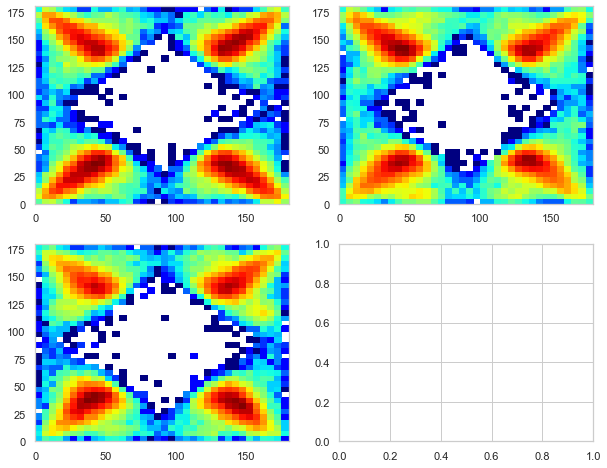

In [25]:
fig, ax = plt.subplots(2,2,figsize=((10,8)))

contact=np.where(Stackparams['Lig_ring.0'][125][:,0]<= 0.5)
H125=ax[0,0].hist2d(Stackparams['Lig_ring.0'][125][:,1][contact],Stackparams['Lig_ring.0'][125][:,2][contact], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
np.savetxt(outdir+'Lig_ring.0.Y125.stackparams.all.dat',Stackparams['Lig_ring.0'][125],fmt='%.4f')
np.savetxt(outdir+'Lig_ring.0.Y125.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][125][contact],fmt='%.4f')

contact=np.where(Stackparams['Lig_ring.0'][133][:,0]<= 0.5)
H133=ax[0,1].hist2d(Stackparams['Lig_ring.0'][133][:,1][contact],Stackparams['Lig_ring.0'][133][:,2][contact], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
np.savetxt(outdir+'Lig_ring.0.Y133.stackparams.all.dat',Stackparams['Lig_ring.0'][133],fmt='%.4f')
np.savetxt(outdir+'Lig_ring.0.Y133.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][133][contact],fmt='%.4f')

contact=np.where(Stackparams['Lig_ring.0'][136][:,0]<= 0.5)
H136=ax[1,0].hist2d(Stackparams['Lig_ring.0'][136][:,1][contact],Stackparams['Lig_ring.0'][136][:,2][contact], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
np.savetxt(outdir+'Lig_ring.0.Y136.stackparams.all.dat',Stackparams['Lig_ring.0'][136],fmt='%.4f')
np.savetxt(outdir+'Lig_ring.0.Y136.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][136][contact],fmt='%.4f')


plt.savefig(outdir+'StackingHistograms.png')
plt.show()
#plt.clf()

[ 4 12 15]
Aromatic Stacking Fraction, All Frames: [[1.21000000e+02 0.00000000e+00 0.00000000e+00]
 [1.22000000e+02 0.00000000e+00 0.00000000e+00]
 [1.23000000e+02 0.00000000e+00 0.00000000e+00]
 [1.24000000e+02 0.00000000e+00 0.00000000e+00]
 [1.25000000e+02 1.86790255e-01 1.09174423e-02]
 [1.26000000e+02 0.00000000e+00 0.00000000e+00]
 [1.27000000e+02 0.00000000e+00 0.00000000e+00]
 [1.28000000e+02 0.00000000e+00 0.00000000e+00]
 [1.29000000e+02 0.00000000e+00 0.00000000e+00]
 [1.30000000e+02 0.00000000e+00 0.00000000e+00]
 [1.31000000e+02 0.00000000e+00 0.00000000e+00]
 [1.32000000e+02 0.00000000e+00 0.00000000e+00]
 [1.33000000e+02 2.59298459e-01 1.19588759e-02]
 [1.34000000e+02 0.00000000e+00 0.00000000e+00]
 [1.35000000e+02 0.00000000e+00 0.00000000e+00]
 [1.36000000e+02 1.97767006e-01 1.54604822e-02]
 [1.37000000e+02 0.00000000e+00 0.00000000e+00]
 [1.38000000e+02 0.00000000e+00 0.00000000e+00]
 [1.39000000e+02 0.00000000e+00 0.00000000e+00]
 [1.40000000e+02 0.00000000e+00 0.000

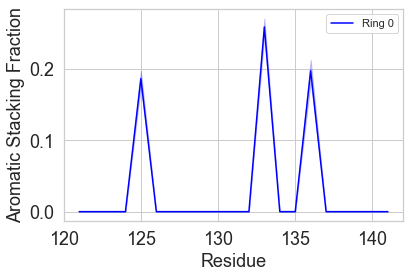

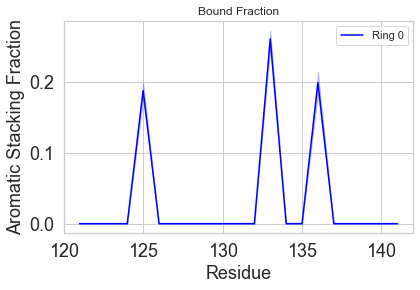

In [26]:
# Cast aromatic contacts as per residue in each frame
residues = 21
residue_offset = 121
residue_number = range(residue_offset, residue_offset+residues)
aro_res_index = np.array(prot_ring_index)-residue_offset

aromatic_stacking_contacts_r0 = np.zeros((n_frames, residues))

aromatic_contacts_r0 = np.zeros((n_frames, residues))

print(aro_res_index)

for i in range(0, len(aro_res_index)):
    aromatic_stacking_contacts_r0[:, aro_res_index[i]
                                  ] = Ringstacked['Lig_ring.0'][:, i]
    aromatic_contacts_r0[:, aro_res_index[i]
                         ] = Aro_Contacts['Lig_ring.0'][:, i]


np.savetxt(outdir+'aromatic_stacking.traj.r0.dat',
           aromatic_stacking_contacts_r0, '%i')
aro_r0_ave, aro_r0_pyb_be = get_blockerrors_pyblock(
    aromatic_stacking_contacts_r0, 1.0)
aro_r0_by_res = np.column_stack(
    (residue_number_offset, aro_r0_ave, aro_r0_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.r0.be.dat', aro_r0_by_res)


print("Aromatic Stacking Fraction, All Frames:",aro_r0_by_res)

plt.plot(aro_r0_by_res[:, 0], aro_r0_by_res[:, 1],
         label='Ring 0', color='blue')
plt.fill_between(aro_r0_by_res[:, 0], aro_r0_by_res[:, 1]+aro_r0_by_res[:, 2],
                 aro_r0_by_res[:, 1]-aro_r0_by_res[:, 2], alpha=0.2, color='blue')



plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Aromatic Stacking Fraction', size=18)
plt.tick_params(labelsize=18)
#plt.xlim(residue_offset, residue_offset+residues-1)
#plt.ylim(0, 0.25)
plt.tight_layout()
plt.savefig(outdir+'AromaticStackingFraction.pdf')
plt.show()
plt.clf()


# Scale For Bound Faction

aro_r0_by_res_bf = np.column_stack(
    (residue_number_offset, aro_r0_ave/boundfrac, aro_r0_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.r0.be.dat', aro_r0_by_res_bf)


plt.plot(aro_r0_by_res_bf[:, 0],
         aro_r0_by_res_bf[:, 1], label='Ring 0', color='blue')
plt.fill_between(aro_r0_by_res_bf[:, 0], aro_r0_by_res_bf[:, 1]+aro_r0_by_res_bf[:, 2],
                 aro_r0_by_res_bf[:, 1]-aro_r0_by_res_bf[:, 2], alpha=0.2, color='blue')


plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Aromatic Stacking Fraction', size=18)
plt.tick_params(labelsize=18)
#plt.xlim(121, 140)
#plt.ylim(0, 0.25)
plt.tight_layout()
plt.title("Bound Fraction")
plt.savefig(outdir+'AromaticStackingFraction.BoundFraction.pdf')
plt.show()


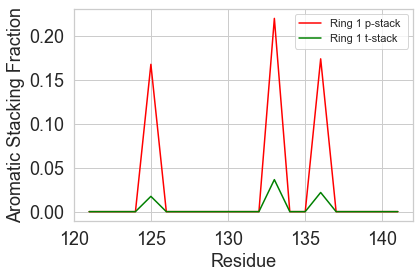

<Figure size 432x288 with 0 Axes>

In [27]:
# Cast aromatic contacts as per residue in each frame
residues = 21
residue_offset = 121
residue_number = range(residue_offset, residue_offset+residues)
aro_res_index = np.array(prot_ring_index)-residue_offset

aromatic_stacking_contacts_r0_p = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r0_t = np.zeros((n_frames, residues))
#aromatic_stacking_contacts_r1_p = np.zeros((n_frames, residues))
#aromatic_stacking_contacts_r1_t = np.zeros((n_frames, residues))

for i in range(0, len(aro_res_index)):
    aromatic_stacking_contacts_r0_p[:,
                                    aro_res_index[i]] = Pstack['Lig_ring.0'][:, i]
#    aromatic_stacking_contacts_r1_p[:,
#                                    aro_res_index[i]] = Pstack['Lig_ring.1'][:, i]
    aromatic_stacking_contacts_r0_t[:,
                                    aro_res_index[i]] = Tstack['Lig_ring.0'][:, i]
#    aromatic_stacking_contacts_r1_t[:,
#                                    aro_res_index[i]] = Tstack['Lig_ring.1'][:, i]

np.savetxt(outdir+'aromatic_pstacking.traj.r0.dat',
           aromatic_stacking_contacts_r0_p, '%i')
aromatic_pstacking_fraction_r0 = np.sum(
    aromatic_stacking_contacts_r0_p, axis=0)/trj.n_frames
#np.savetxt(outdir+'aromatic_pstacking.traj.r1.dat',
#           aromatic_stacking_contacts_r1_p, '%i')
#aromatic_pstacking_fraction_r1 = np.sum(
#    aromatic_stacking_contacts_r1_p, axis=0)/trj.n_frames

np.savetxt(outdir+'aromatic_tstacking.traj.r0.dat',
           aromatic_stacking_contacts_r0_t, '%i')
aromatic_tstacking_fraction_r0 = np.sum(
    aromatic_stacking_contacts_r0_t, axis=0)/trj.n_frames
#np.savetxt(outdir+'aromatic_tstacking.traj.r1.dat',
#           aromatic_stacking_contacts_r1_t, '%i')
#aromatic_tstacking_fraction_r1 = np.sum(
#    aromatic_stacking_contacts_r1_t, axis=0)/trj.n_frames


aromatic_by_res_r0_p = np.column_stack(
    (residue_number, aromatic_pstacking_fraction_r0/boundfrac))
np.savetxt(outdir+'aromatic_pstacking.fraction.r0.dat',
           aromatic_by_res_r0_p, fmt='%.4f')
aromatic_by_res_r0_t = np.column_stack(
    (residue_number, aromatic_tstacking_fraction_r0/boundfrac))
np.savetxt(outdir+'aromatic_tstacking.fraction.r0.dat',
           aromatic_by_res_r0_t, fmt='%.4f')
#aromatic_by_res_r1_p = np.column_stack(
#    (residue_number, aromatic_pstacking_fraction_r1/boundfrac))
#np.savetxt(outdir+'aromatic_pstacking.fraction.r1.dat',
#           aromatic_by_res_r1_p, fmt='%.4f')
#aromatic_by_res_r1_t = np.column_stack(
#    (residue_number, aromatic_tstacking_fraction_r1/boundfrac))
#np.savetxt(outdir+'aromatic_tstacking.fraction.r1.dat',
#           aromatic_by_res_r1_t, fmt='%.4f')


#plt.plot(residue_number, aromatic_pstacking_fraction_r1,
#         label='Ring 1 p-stack ', color='blue')
#plt.plot(residue_number, aromatic_tstacking_fraction_r1,
#         label='Ring 1 t-stack ', color='darkblue')
plt.plot(residue_number, aromatic_pstacking_fraction_r0,
         label='Ring 1 p-stack ', color='red')
plt.plot(residue_number, aromatic_tstacking_fraction_r0,
         label='Ring 1 t-stack ', color='green')

plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Aromatic Stacking Fraction', size=18)
plt.tick_params(labelsize=18)
#plt.xlim(residue_offset, residue_offset+residues-1)
#plt.ylim(0, 0.15)
plt.tight_layout()
plt.savefig(outdir+'AromaticStackingFraction.p_vs_t.pdf')
plt.show()
plt.clf()


In [28]:
sidechains = len(prot_rings)
print(n_frames)
stack_distance_cutoff = 0.65
bound_fraction = boundfrac
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print("Ring_Contacts", "Stacked", "P-stacked", "T-stacked")
for j in range(0, sidechains):
    name = prot_ring_index[j]
    res = prot_ring_name[j]
    theta = Stackparams['Lig_ring.0'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    phi = Stackparams['Lig_ring.0'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    # Procacci: We define p-stack a domain S in the r, θ, ϕ space as the subset of points such that 3.5 < r < 4.5 Å, θ < 15° and ϕ < 30°.
    # Here: p-stack a domain S in the r<0.6, θ < 45° and ϕ < 45°.
    contacts = np.where(Stackparams['Lig_ring.0']
                        [name][:, 0] <= stack_distance_cutoff)
    b = np.where(newtheta[contacts] <= 45)
    c = np.where(newphi[contacts] <= 60)
    pstack = np.intersect1d(b, c)
    # Procacci: T-stack is the volume of the following T domain: 4.5 < r < 5.5 Å, 75° < θ < 90° and ϕ < 15°.
    # Here :  r < 6.0 Å, 75° < θ < 90° and ϕ < 15°.
    d = np.where(newtheta[contacts] >= 75)
    e = np.where(newphi[contacts] <= 60)
    tstack = np.intersect1d(d, e)
    print(name, res)
    arocontacts = len(contacts[0])/n_frames
    stacked = (len(pstack)+len(tstack))/n_frames
    pstacked = len(pstack)/n_frames
    tstacked = len(tstack)/n_frames
    print("Ring 0: %6.3lf %6.3lf %6.3lf %6.3lf" %
          (arocontacts, stacked, pstacked, tstacked))

#    theta = Stackparams['Lig_ring.1'][name][:, 3]
#    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
#    phi = Stackparams['Lig_ring.1'][name][:, 4]
#    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
#    # Procacci: We define p-stack a domain S in the r, θ, ϕ space as the subset of points such that 3.5 < r < 4.5 Å, θ < 15° and ϕ < 30°.
#    # Here: p-stack a domain S in the r<0.6, θ < 45° and ϕ < 60°.
#    contacts = np.where(Stackparams['Lig_ring.1']
#                        [name][:, 0] <= stack_distance_cutoff)
#    b = np.where(newtheta[contacts] <= 45)
#    c = np.where(newphi[contacts] <= 60)
#    pstack = np.intersect1d(b, c)
#    # Procacci: T-stack is the volume of the following T domain: 4.5 < r < 5.5 Å, 75° < θ < 90° and ϕ < 15°.
#    # Here :  r < 7.5 Å, 45° < θ and ϕ < 60°.
#    d = np.where(newtheta[contacts] >= 75)
#    e = np.where(newphi[contacts] <= 60)
#    tstack = np.intersect1d(c, e)
#    arocontacts = len(contacts[0])/n_frames
#    stacked = (len(pstack)+len(tstack))/n_frames
#    pstacked = len(pstack)/n_frames
#    tstacked = len(tstack)/n_frames
#    print("Ring 1: %6.3lf %6.3lf %6.3lf %6.3lf" %
#          (arocontacts, stacked, pstacked, tstacked))


366593
Ring_Contacts Stacked P-stacked T-stacked
125 TYR125
Ring 0:  0.235  0.176  0.168  0.009
133 TYR133
Ring 0:  0.336  0.238  0.220  0.018
136 TYR136
Ring 0:  0.254  0.185  0.174  0.011


In [29]:
hbonds = print_donors_acceptors(
    trj[0], angle_cutoff=150, distance_cutoff=0.35, lig_donor_index=lig_hbond_donors)


nh_donors [(0, 8), (12, 20), (19, 24), (19, 25), (26, 35), (41, 46), (51, 63), (72, 81), (87, 95), (118, 124), (129, 138), (144, 153), (159, 163), (166, 178), (187, 196), (195, 202), (195, 203), (204, 212), (216, 228), (237, 246), (266, 275), (281, 287)]
ASP121-N ASP121-H
ASN122-N ASN122-H
ASN122-ND2 ASN122-HD21
ASN122-ND2 ASN122-HD22
GLU123-N GLU123-H
ALA124-N ALA124-H
TYR125-N TYR125-H
GLU126-N GLU126-H
MET127-N MET127-H
SER129-N SER129-H
GLU130-N GLU130-H
GLU131-N GLU131-H
GLY132-N GLY132-H
TYR133-N TYR133-H
GLN134-N GLN134-H
GLN134-NE2 GLN134-HE21
GLN134-NE2 GLN134-HE22
ASP135-N ASP135-H
TYR136-N TYR136-H
GLU137-N GLU137-H
GLU139-N GLU139-H
ALA140-N ALA140-H
oh_donors [(62, 71), (123, 128), (177, 186), (227, 236)]
TYR125-OH TYR125-HH
SER129-OG SER129-HG
TYR133-OH TYR133-HH
TYR136-OH TYR136-HH
sh_donors []
<1>1-N <1>1-H
<1>1-N <1>1-H
acceptors
ASP121-N
ASP121-O
ASP121-OD1
ASP121-OD2
ASN122-N
ASN122-O
ASN122-OD1
ASN122-ND2
GLU123-N
GLU123-O
GLU123-OE1
GLU123-OE2
ALA124-N
ALA124-O
TYR

In [30]:
# Select Ligand Residues
ligand = top.select("resid 21")
# Select Protein Residues
protein = top.select("resid 0 to 20")

residues=21

HBond_PD = np.zeros((n_frames, residues))
HBond_LD = np.zeros((n_frames, residues))
Hbond_pairs_PD = {}
Hbond_pairs_LD = {}


def add_hbond_pair(donor, acceptor, hbond_pairs, donor_res):
    if donor_res not in hbond_pairs:
        hbond_pairs[donor_res] = {}
    if donor not in hbond_pairs[donor_res]:
        hbond_pairs[donor_res][donor] = {}
    if acceptor not in hbond_pairs[donor_res][donor]:
        hbond_pairs[donor_res][donor][acceptor] = 0
    hbond_pairs[donor_res][donor][acceptor] += 1

# Donor & Acceptors Definitions from DESRES paper:
# ligdon = mol.select('chain B and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
# ligacc = mol.select('chain B and (nitrogen or oxygen or sulfur)')
# protdon = mol.select('chain A and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
# protacc = mol.select('chain A and (nitrogen or oxygen or sulfur)')


for frame in range(n_frames):
    hbonds = baker_hubbard2(trj[frame], angle_cutoff=150,
                            distance_cutoff=0.35)# lig_donor_index=lig_hbond_donors)
    for hbond in hbonds:
        if ((hbond[0] in protein) and (hbond[2] in ligand)):
            donor = top.atom(hbond[0])
            donor_id = hbond[0]
            donor_res = top.atom(hbond[0]).residue.resSeq
            acc = top.atom(hbond[2])
            acc = top.atom(hbond[2])
            acc_res = top.atom(hbond[2]).residue.resSeq
            HBond_PD[frame][donor_res-121] = 1
            add_hbond_pair(donor, acc, Hbond_pairs_PD, donor_res)
        if ((hbond[0] in ligand) and (hbond[2] in protein)):
            donor = top.atom(hbond[0])
            donor_id = hbond[0]
            donor_res = top.atom(hbond[0]).residue.resSeq
            acc = top.atom(hbond[2])
            acc_id = hbond[2]
            acc_res = top.atom(hbond[2]).residue.resSeq
            HBond_LD[frame][acc_res-121] = 1
            add_hbond_pair(donor, acc, Hbond_pairs_LD, acc_res)


In [31]:
residues = 21
residue_offset = 121
residue_number = range(residue_offset, residue_offset+residues)

residue_number_offset = range(residue_offset, residue_offset+residues)

HB_Total = HBond_PD+HBond_LD
HB_Total_ave = np.mean(HB_Total, axis=0)


PD_ave = np.mean(HBond_PD, axis=0)
LD_ave = np.mean(HBond_LD, axis=0)
for i in Hbond_pairs_PD:
    print(i, i+residue_offset, Hbond_pairs_PD[i])

print("HBond_Ligand Donors")

for i in Hbond_pairs_LD:
    print(i, Hbond_pairs_LD[i])

np.savetxt(outdir+'Hbond.PD.traj.dat', HBond_PD, '%i')
np.savetxt(outdir+'Hbond.LD.traj.dat', HBond_LD, '%i')
np.savetxt(outdir+'Hbond.all.traj.dat', HB_Total, '%i')
hbond_by_res = np.column_stack((residue_number, HB_Total_ave))
hbond_by_res_PD = np.column_stack((residue_number, PD_ave))
hbond_by_res_LD = np.column_stack((residue_number, LD_ave))


HBond_PD_ave, HBond_PD_pyb_be = get_blockerrors_pyblock(HBond_PD, 1.0)
HBond_LD_ave, HBond_LD_pyb_be = get_blockerrors_pyblock(HBond_LD, 1.0)
HBond_ave, HBond_pyb_be = get_blockerrors_pyblock(HB_Total, 1.0)

Hbond_by_res = np.column_stack(
    (residue_number_offset, HBond_ave, HBond_pyb_be))
Hbond_by_res_bf = np.column_stack(
    (residue_number_offset, HBond_ave/boundfrac, HBond_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.be.dat', Hbond_by_res)
np.savetxt(outdir+'hbond_fraction.boundfraction.be.dat', Hbond_by_res_bf)


Hbond_by_res_LD = np.column_stack(
    (residue_number_offset, HBond_LD_ave, HBond_LD_pyb_be))
np.savetxt(outdir+'hbond_fraction.PD.be.dat', Hbond_by_res_LD)
Hbond_by_res_LD_bf = np.column_stack(
    (residue_number_offset, HBond_LD_ave/boundfrac, HBond_LD_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.PD.boundfraction.be.dat', Hbond_by_res_LD_bf)


Hbond_by_res_PD = np.column_stack(
    (residue_number_offset, HBond_PD_ave, HBond_PD_pyb_be))
np.savetxt(outdir+'hbond_fraction.LD.be.dat', Hbond_by_res_PD)
Hbond_by_res_PD_bf = np.column_stack(
    (residue_number_offset, HBond_PD_ave/boundfrac, HBond_PD_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.PD.boundfraction.be.dat', Hbond_by_res_PD_bf)


136 257 {TYR136-OH: {<1>1-O: 269, <1>1-S: 276, <1>1-O: 177, <1>1-O: 280, <1>1-N: 43, <1>1-N: 5, <1>1-N: 2}, TYR136-N: {<1>1-O: 934, <1>1-N: 114, <1>1-S: 3443, <1>1-O: 6383, <1>1-O: 594, <1>1-N: 172, <1>1-N: 6}}
123 244 {GLU123-N: {<1>1-O: 872, <1>1-O: 253, <1>1-S: 911, <1>1-O: 341, <1>1-N: 69, <1>1-N: 36, <1>1-N: 14}}
139 260 {GLU139-N: {<1>1-S: 1208, <1>1-O: 830, <1>1-O: 808, <1>1-N: 14, <1>1-O: 542, <1>1-N: 100, <1>1-N: 27}}
125 246 {TYR125-N: {<1>1-S: 1144, <1>1-O: 1073, <1>1-O: 733, <1>1-O: 838, <1>1-N: 77, <1>1-N: 4, <1>1-N: 11}, TYR125-OH: {<1>1-O: 464, <1>1-O: 378, <1>1-S: 473, <1>1-O: 304, <1>1-N: 39, <1>1-N: 5, <1>1-N: 1}}
121 242 {ASP121-N: {<1>1-S: 241, <1>1-O: 165, <1>1-O: 32, <1>1-O: 50, <1>1-N: 59, <1>1-N: 2, <1>1-N: 3}}
135 256 {ASP135-N: {<1>1-O: 413, <1>1-S: 617, <1>1-O: 497, <1>1-O: 305, <1>1-N: 172, <1>1-N: 30, <1>1-N: 31}}
130 251 {GLU130-N: {<1>1-O: 3369, <1>1-O: 2481, <1>1-S: 3771, <1>1-O: 2832, <1>1-N: 200, <1>1-N: 28, <1>1-N: 54}}
129 250 {SER129-OG: {<1>1-O: 45

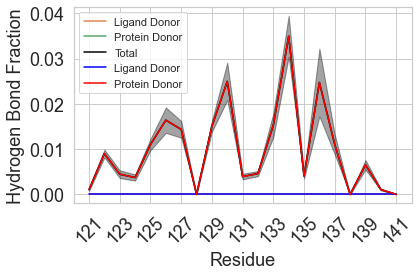

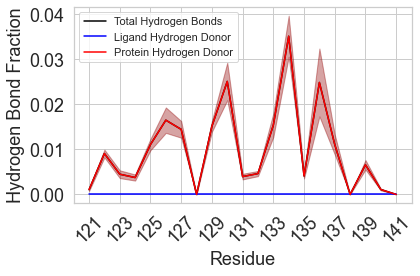

<Figure size 432x288 with 0 Axes>

In [32]:
residue_number = range(residue_offset, residue_offset+residues)
#plt.figure(figsize=(8,8))
plt.plot(residue_number, HB_Total_ave)
plt.plot(residue_number, LD_ave, label="Ligand Donor")
plt.plot(residue_number, PD_ave, label="Protein Donor")


plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1], color='black', label='Total')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]+Hbond_by_res[:, 2],
                 Hbond_by_res[:, 1]-Hbond_by_res[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_LD[:, 0], Hbond_by_res_LD[:, 1],
         color='blue', label='Ligand Donor')
plt.fill_between(Hbond_by_res_LD[:, 0], Hbond_by_res_LD[:, 1]+Hbond_by_res_LD[:, 2],
                 Hbond_by_res_LD[:, 1]-Hbond_by_res_LD[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_PD[:, 0], Hbond_by_res_PD[:, 1],
         color='red', label='Protein Donor')
plt.fill_between(Hbond_by_res_PD[:, 0], Hbond_by_res_PD[:, 1]+Hbond_by_res_PD[:, 2],
                 Hbond_by_res_PD[:, 1]-Hbond_by_res_PD[:, 2], color='black', alpha=0.2)


plt.legend()
#plt.ylim(0, 0.10)
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrogen Bond Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xticks(np.arange(121,142,2),rotation=45)
plt.tight_layout()
plt.savefig(outdir+'HbondFraction.allframes.pdf')
plt.show()
plt.clf()

#plt.figure(figsize=(10,8))
plt.plot(Hbond_by_res_bf[:, 0], Hbond_by_res_bf[:, 1],
         color='black', label='Total Hydrogen Bonds')
plt.fill_between(Hbond_by_res_bf[:, 0], Hbond_by_res_bf[:, 1]+Hbond_by_res_bf[:, 2],
                 Hbond_by_res_bf[:, 1]-Hbond_by_res_bf[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_LD_bf[:, 0], Hbond_by_res_LD_bf[:,
         1], color='blue', label='Ligand Hydrogen Donor')
plt.fill_between(Hbond_by_res_LD_bf[:, 0], Hbond_by_res_LD_bf[:, 1]+Hbond_by_res_LD_bf[:, 2],
                 Hbond_by_res_LD_bf[:, 1]-Hbond_by_res_LD_bf[:, 2], color='blue', alpha=0.2)
plt.plot(Hbond_by_res_PD_bf[:, 0], Hbond_by_res_PD_bf[:,
         1], color='red', label='Protein Hydrogen Donor')
plt.fill_between(Hbond_by_res_PD_bf[:, 0], Hbond_by_res_PD_bf[:, 1]+Hbond_by_res_PD_bf[:, 2],
                 Hbond_by_res_PD_bf[:, 1]-Hbond_by_res_PD_bf[:, 2], color='red', alpha=0.2)


plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrogen Bond Fraction', size=18)
#plt.ylim(0, 0.10)
plt.tick_params(labelsize=18)
plt.xticks(np.arange(121,142,2),rotation=45)
plt.tight_layout()
plt.savefig(outdir+'HbondFraction.boundfraction.pdf')
plt.show()
plt.clf()


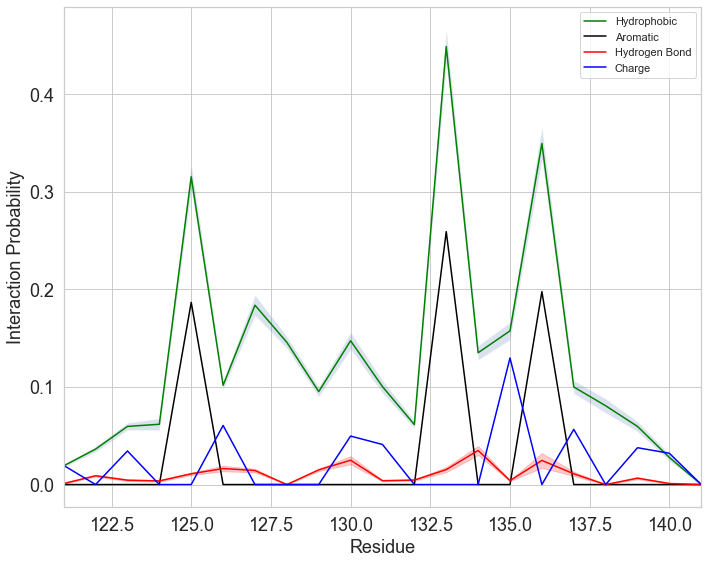

<Figure size 432x288 with 0 Axes>

In [33]:
plt.figure(figsize=(10,8))
plt.plot(residue_number_offset,
         hphob_by_res[:, 1], label='Hydrophobic', color='green')
plt.fill_between(residue_number_offset,
                 hphob_by_res[:, 1]+hphob_by_res[:, 2], hphob_by_res[:, 1]-hphob_by_res[:, 2], alpha=0.2)

plt.plot(aro_r0_by_res[:, 0], aro_r0_by_res[:, 1], color='black', label='Aromatic')
plt.fill_between(aro_r0_by_res[:, 0]+121, aro_r0_by_res[:, 1]+aro_r0_by_res[:, 2],
                 aro_r0_by_res[:, 1]-aro_r0_by_res[:, 2], color='black', alpha=0.2)

plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1],
         label='Hydrogen Bond', color='red')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]+Hbond_by_res[:, 2],
                 Hbond_by_res[:, 1]-Hbond_by_res[:, 2], color='red', alpha=0.2)

plt.plot(Hbond_by_res[:, 0],charge_contact_fraction,label='Charge',c='blue')


plt.xlabel('Residue', size=18)
plt.ylabel('Interaction Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.legend()
plt.tight_layout()
plt.savefig(outdir+'LigandInteractions.allframes.pdf')
#plt.ylim(0, 0.6)
plt.show()
plt.clf()


In [34]:
bound_fraction

0.9944270621643075

In [35]:
print(np.shape(HB_Total),np.shape(HBond_PD),np.shape(HBond_LD),np.shape(aromatic_stacking_contacts_r0))
print(np.shape(Hphob_res_contacts),np.shape(Charge_Contacts))


(366593, 21) (366593, 21) (366593, 21) (366593, 21)
(366593, 21) (366593, 21)


In [36]:
D135contacts=np.where(Charge_Contacts[:,14]==1)
len(D135contacts[0])
HB_Cond=np.mean(HB_Total[D135contacts], axis = 0)
Stack_Cond=np.mean(aromatic_stacking_contacts_r0[D135contacts], axis = 0)
Hphob_Cond=np.mean(Hphob_res_contacts[D135contacts],axis=0)
Charge_Cond=np.mean(Charge_Contacts[D135contacts],axis=0)


np.savetxt(outdir+'Hbond.conditionalprob.D135charge.dat',HB_Cond,fmt='%.4f')
np.savetxt(outdir+'Stacking.conditionalprob.D135charge.dat',Stack_Cond,fmt='%.4f')
np.savetxt(outdir+'Hphob.conditionalprob.D135charge.dat',Hphob_Cond,fmt='%.4f')
np.savetxt(outdir+'Charge.conditionalprob.D135charge.dat',Charge_Cond,fmt='%.4f')


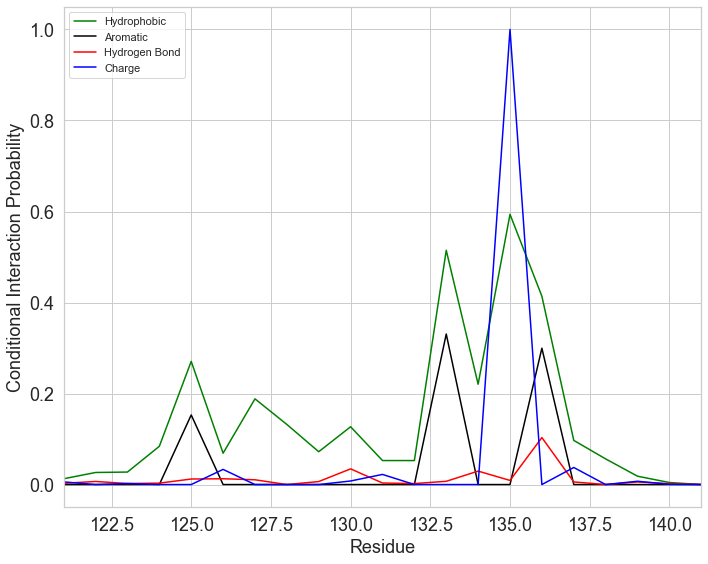

In [37]:
plt.figure(figsize=(10,8))
plt.plot(residue_number,Hphob_Cond,label='Hydrophobic',c='green')
plt.plot(residue_number,Stack_Cond,label='Aromatic',c='black')
plt.plot(residue_number,HB_Cond,label='Hydrogen Bond',c='red')
plt.plot(residue_number,Charge_Cond,label='Charge',c='blue')

plt.xlabel('Residue', size=18)
plt.ylabel('Conditional Interaction Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('LigandInteractions.D135ChargeContacts.png')
plt.show()
#plt.clf()

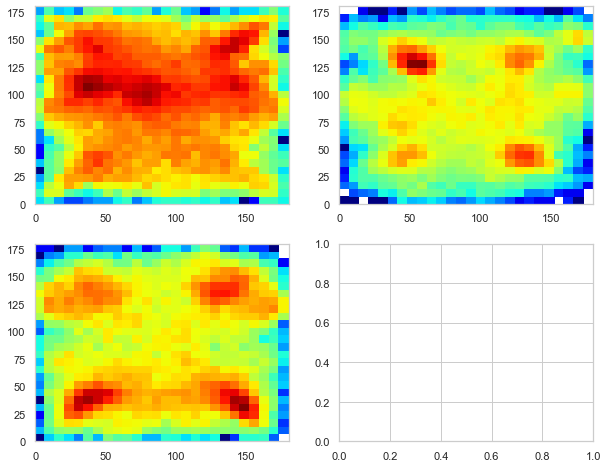

In [38]:
fig, ax = plt.subplots(2,2,figsize=((10,8)))

contact=D135contacts
contact2=np.where(Stackparams['Lig_ring.0'][133][:,0]<= 0.5)

H125=ax[0,0].hist2d(Stackparams['Lig_ring.0'][125][:,1][contact],Stackparams['Lig_ring.0'][125][:,2][contact], bins=26,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
H133=ax[0,1].hist2d(Stackparams['Lig_ring.0'][133][:,1][contact],Stackparams['Lig_ring.0'][133][:,2][contact], bins=26,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')
H136=ax[1,0].hist2d(Stackparams['Lig_ring.0'][136][:,1][contact],Stackparams['Lig_ring.0'][136][:,2][contact], bins=26,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')

plt.savefig(outdir+'StackingHistograms.D135.png')
#plt.clf()
plt.show()

In [39]:
contact=D135contacts
contact2=np.where(Stackparams['Lig_ring.0'][125][:,0]<= 0.5)
contact3=np.intersect1d(contact,contact2)
print(contact3)

[  5454   5455   5456 ... 366174 366175 366176]


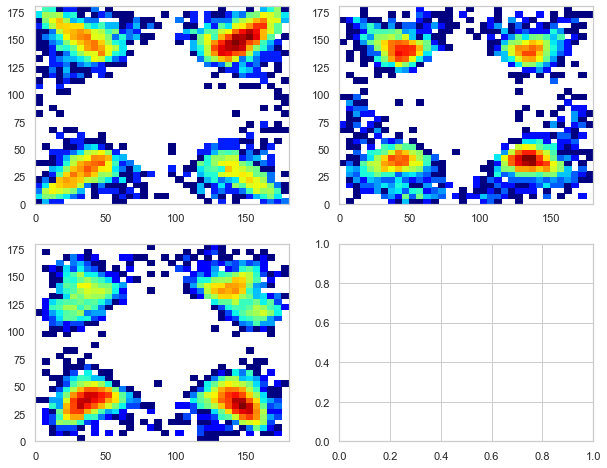

In [40]:
fig, ax = plt.subplots(2,2,figsize=((10,8)))

H125=ax[0,0].hist2d(Stackparams['Lig_ring.0'][125][:,1][contact3],Stackparams['Lig_ring.0'][125][:,2][contact3], bins=36,range=[[0,180],[0,180]],norm=colors.LogNorm(),cmap='jet')
np.savetxt(outdir+'Lig_ring.0.Y125.D135contact.stackparams.all.dat',Stackparams['Lig_ring.0'][125][contact3][:,1:3],fmt='%.4f')
np.savetxt(outdir+'Lig_ring.0.Y125.D135contact.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][125][contact3][:,1:3],fmt='%.4f')

contact2=np.where(Stackparams['Lig_ring.0'][133][:,0]<= 0.5)
contact3=np.intersect1d(contact,contact2)
H133=ax[0,1].hist2d(Stackparams['Lig_ring.0'][133][:,1][contact3],Stackparams['Lig_ring.0'][133][:,2][contact3], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')

np.savetxt(outdir+'Lig_ring.0.Y133.D135contact.stackparams.all.dat',Stackparams['Lig_ring.0'][133][contact3][:,1:3],fmt='%.4f')
np.savetxt(outdir+'Lig_ring.0.Y133.D135contact.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][133][contact3][:,1:3],fmt='%.4f')

contact2=np.where(Stackparams['Lig_ring.0'][136][:,0]<= 0.5)
contact3=np.intersect1d(contact,contact2)
H136=ax[1,0].hist2d(Stackparams['Lig_ring.0'][136][:,1][contact3],Stackparams['Lig_ring.0'][136][:,2][contact3], bins=36,range=[[0,180],[0,180]], norm=colors.LogNorm(),cmap='jet')


np.savetxt(outdir+'Lig_ring.0.Y136.D135contact.stackparams.all.dat',Stackparams['Lig_ring.0'][136][contact3][:,1:3],fmt='%.4f')
np.savetxt(outdir+'Lig_ring.0.Y136.D135contact.stackparams.dist_lt_0.5.dat',Stackparams['Lig_ring.0'][136][contact3][:,1:3],fmt='%.4f')

plt.savefig(outdir+'StackingHistograms.D135.dist_lt_0.5.png')
plt.show()
#plt.clf()